In [1]:
%cd C:\\Users\\s\\Downloads\\machine_learning\\machine-learning-ex8\\ex8
%pwd

C:\Users\s\Downloads\machine_learning\machine-learning-ex8\ex8


'C:\\Users\\s\\Downloads\\machine_learning\\machine-learning-ex8\\ex8'

## Anomaly detection

(307, 2)
(307, 2) (307, 1)


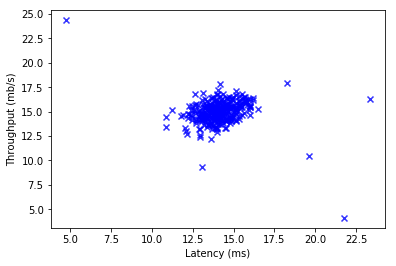

In [86]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt


data1 = loadmat('ex8data1.mat')
x10 = data1['X']
print(x10.shape)
xval10 = data1['Xval']
yval_10 = data1['yval']
print(xval10.shape, yval_10.shape)

plt.scatter(x10[:, 0], x10[:,1], c='b', marker='x',alpha=0.8)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

### Estimating parameters for a Gaussian

In [68]:
def estimate_gaussian(x):
    m = x.shape[0]
    mu = np.mean(x, axis=0)
  # sigma2 = x.var(axis=0)
    sigma2 = 1 / m * np.sum((x - mu) ** 2, axis=0)
    
    return mu.reshape(1, -1), sigma2.reshape(1, -1)


mu10, sigma2_10 = estimate_gaussian(x10)
print(mu10, sigma2_10)

[[14.11222578 14.99771051]] [[1.83263141 1.70974533]]


In [125]:
from scipy import stats


def p(x, mu, sigma2):
    m, n = x.shape
    p_list = []
    
    for j in range(m):
        p = 1
        for i in range(n):
            p *= stats.norm.pdf(x[j, i], mu[0, i], np.sqrt(sigma2[0, i]))
        p_list.append(p)
    p_array = np.array(p_list).reshape(-1, 1)
    return p_array


p10 = p(x10, mu10, sigma2_10)
print(p10[:5])
pval10 = p(xval10, mu10, sigma2_10)
print(pval10[:5])

[[0.06470829]
 [0.05030417]
 [0.07245035]
 [0.05031575]
 [0.06368497]]
[[0.04163207]
 [0.08190901]
 [0.04071578]
 [0.06190003]
 [0.07118676]]


### Selecting the threshold

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


8.990852779269493e-05 0.8750000000000001


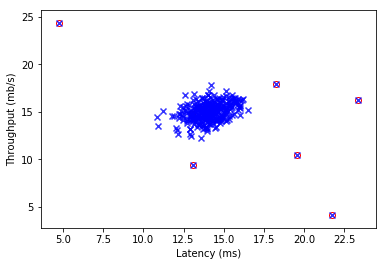

In [126]:
def select_threshold(yval, pval):
    best_epsilon = 0
    best_f1 = 0
    stepsize = (np.max(pval) - np.min(pval)) / 1000
    for epsilon in np.arange(np.min(pval), np.max(pval), stepsize):
        predictions = np.array(pval < epsilon)
        fp = np.sum(np.array(predictions == 1) & np.array(yval == 0)).astype(float)
        fn = np.sum(np.array(predictions == 0) & np.array(yval == 1)).astype(float)
        tp = np.sum(np.array(predictions == 1) & np.array(yval == 1)).astype(float)
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * precision * recall / (precision + recall)
        
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
            
    return best_epsilon, best_f1


best_epsilon10, best_f1_10 = select_threshold(yval_10, pval10)
print(best_epsilon10, best_f1_10)

outliers = np.where(p10 < best_epsilon10)
plt.scatter(x10[outliers, 0], x10[outliers, 1], c='w', marker='o', edgecolors='r')
plt.scatter(x10[:, 0], x10[:,1], c='b', marker='x',alpha=0.8)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

### High dimensional dataset

In [132]:
data2 = loadmat('ex8data2.mat')
x20 = data2['X']
xval_20 = data2['Xval']
yval_20 = data2['yval']
print(x20.shape, xval_20.shape, yval_20.shape)

def multivariate_gaussian(x, mu, sigma2):
    k = x.shape[0]
    sigma2 = np.diag(sigma2.ravel())
    x = x - mu
    p = (2 * np.pi) ** (-k / 2) * np.linalg.det(sigma2) ** (-0.5) * np.exp(-0.5 * x.T.dot(np.linalg.pinv(sigma2)).dot(x))
    
    return p

mu20, sigma2_20 = estimate_gaussian(x20)
print(sigma2_20[0, 0])
p20 = np.array([multivariate_gaussian(x.reshape(-1, 1), mu20.reshape(-1, 1), sigma2_20) for x in x20]).reshape(-1, 1)
print(p20[:2])
pval20 = np.array([multivariate_gaussian(x.reshape(-1, 1), mu20.reshape(-1, 1),sigma2_20) for x in xval_20]).reshape(-1, 1)
print(pval20[:2])

best_epsilon20, best_f1_20 = select_threshold(yval_20, pval20)
print(best_epsilon20, best_f1_20)
print('Outliers found:', np.sum(p20 < best_epsilon20))

(1000, 11) (100, 11) (100, 1)
60.97489372687165
[[7.43392946e-18]
 [3.17719963e-18]]
[[5.14552429e-22]
 [1.73600598e-17]]
1.377228890761358e-18 0.6153846153846154
Outliers found: 117


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


## Recommender Systems

In [138]:
data3 = loadmat('ex8_movies.mat')
r30 = data3['R']
y30 = data3['Y']
print(r30.shape, y30.shape)

print(np.mean(y30[0, r30[0, :]]))

(1682, 943) (1682, 943)
4.52067868504772


### Collaborative filtering learning algorithm

In [152]:
params0 = loadmat('ex8_movieParams.mat')
x30 = params0['X']
theta30 = params0['Theta']
params0 = np.hstack((x30.ravel(), theta30.ravel())).ravel()
print(x30.shape, theta30.shape)

def cofi_cost_func(params, y, r, num_users, num_movies, num_features, lam):
    x = params[: num_movies * num_features].reshape(num_movies, num_features)
    theta = params[num_movies * num_features:].reshape(num_users, num_features)
    
    j_temp = ((x.dot(theta.T) - y) * r) ** 2
    j = np.sum(j_temp) / 2 + lam / 2 * np.sum(theta ** 2) + lam / 2 * np.sum(x ** 2)
    
    x_grad = ((x.dot(theta.T) - y) * r).dot(theta) + lam * x
    theta_grad = ((x.dot(theta.T) - y) * r).T.dot(x) + lam * theta
    grad = np.hstack((x_grad.ravel(), theta_grad.ravel())).ravel()
    
    return j, grad


num_users0 = 4
num_movies0 = 5
num_features0 = 3
x30_1 = x30[:num_movies0, :num_features0]
theta30_1 = theta30[:num_users0, :num_features0]
params0_1 = np.hstack((x30_1.ravel(), theta30_1.ravel())).ravel()
y30_1 = y30[:num_movies0, :num_users0]
r30_1 = r30[:num_movies0, :num_users0]

j_1, grad_1 = cofi_cost_func(params0_1, y30_1, r30_1, num_users0, num_movies0, num_features0, 0)
print(j_1)
j_2, grad_2 = cofi_cost_func(params0_1, y30_1, r30_1, num_users0, num_movies0, num_features0, 1.5)
print(j_2)

(1682, 10) (943, 10)
22.224603725685675
31.34405624427422


### Learning movie recommendations

In [167]:
movie = 'movie_ids.txt'
movie_idx = {}
with open(movie, encoding='ISO-8859-1') as f:
    for line in f.readlines():
        line = line.strip().split(' ')
        idx = line[0]
        movie = line[1:]
        movie_idx[int(idx) - 1] = ' '.join(movie)

print(movie_idx[0])

Toy Story (1995)


In [170]:
my_ratings = np.zeros((1682, 1))
my_ratings[0] = 4
my_ratings[97] = 2
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63]= 5
my_ratings[65]= 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354]= 5

for i in range(1682):
    if my_ratings[i] > 0:
        print('Rated {0} for {1}'.format(int(my_ratings[i]), movie_idx[i]))

Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 4 for Alien (1979)
Rated 5 for Die Hard 2 (1990)
Rated 5 for Sphere (1998)


In [177]:
y30_2 = np.hstack((y30, my_ratings))
r30_2 = np.hstack((r30, my_ratings != 0))
print(y30_2.shape, r30_2.shape)

def normalize_ratings(y, r):
    m, n = y.shape
    y_mean = np.zeros((m ,1))
    y_norm = np.zeros(y.shape)
    for i in range(m):
        idx = np.where(r[i, :] == 1)
        y_mean[i] = np.mean(y[i, idx])
        y_norm[i, idx] = y[i, idx] - y_mean[i]
        
    return y_norm, y_mean


y30_norm, y30_mean = normalize_ratings(y30_2, r30_2)
print(y30_norm.mean())
num_users1 = y30_2.shape[1]
num_movies1 = y30_2.shape[0]
num_features1 = 10

x_init = np.random.randn(num_movies1, num_features1)
theta_init = np.random.randn(num_users1, num_features1)
print(x_init.shape, theta_init.shape)
params_init = np.hstack((x_init.ravel(), theta_init.ravel())).ravel()

(1682, 944) (1682, 944)
5.507036456515984e-19
(1682, 10) (944, 10)


In [178]:
from scipy import optimize


res = optimize.minimize(cofi_cost_func, x0=params_init, args=(y30_norm, r30_2, num_users1, num_movies1, num_features1, 10), method='CG', jac=True)
res

     fun: 38951.84755999413
     jac: array([ 1.32383371e-06,  1.82896095e-06, -2.88286309e-06, ...,
        1.53882693e-07,  4.14615819e-08, -5.65635244e-09])
 message: 'Optimization terminated successfully.'
    nfev: 632
     nit: 430
    njev: 632
  status: 0
 success: True
       x: array([-0.39340505,  0.07708225,  0.77692132, ...,  0.02515954,
        0.06865952, -0.0050289 ])

In [180]:
x_res = res.x[: num_movies1 * num_features1].reshape(num_movies1, num_features1)
theta_res = res.x[num_movies1 * num_features1:].reshape(num_users1, num_features1)

pred = x_res.dot(theta_init.T) + y30_mean
my_score = pred[:, -1]
sorted_idx = np.argsort(my_score)
favorite = 10
for i in range(favorite):
    print('Predicting rating {0} for {1}'.format(round(my_score[sorted_idx[-(i + 1)]], 1), movie_idx[sorted_idx[-(i + 1)]]))


Predicting rating 7.8 for English Patient, The (1996)
Predicting rating 5.8 for Seven Years in Tibet (1997)
Predicting rating 5.7 for Good Will Hunting (1997)
Predicting rating 5.6 for Schindler's List (1993)
Predicting rating 5.5 for Silence of the Lambs, The (1991)
Predicting rating 5.5 for Titanic (1997)
Predicting rating 5.4 for Four Weddings and a Funeral (1994)
Predicting rating 5.3 for Dead Poets Society (1989)
Predicting rating 5.3 for Boot, Das (1981)
Predicting rating 5.2 for Fried Green Tomatoes (1991)
